In [4]:
import numpy as np
import skimage
import seaborn as sns

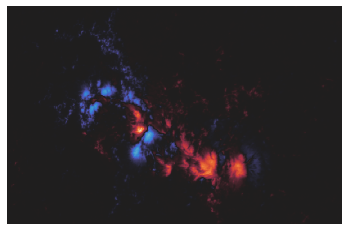

In [28]:
## load test data
data = np.load("test_data.npy")
image = data[0]
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True) # use the grayscale color map
sns.heatmap(image,center=0,cbar=False,xticklabels=False, yticklabels=False)

In [51]:
# I do not split image into pos/neg component this time, but will try to work directly on the image
# set up some physical threshold

PIL_maxGauss = 20 # the PIL candidate pixel cannot have vertical magnetic field component larger than 20 Gauss
PIL_max_gradi = 100 # the "strong" PIL candidate pixel cannot have a graident smaller than 150 Gauss
PIL_min_gradi = 80 # the PIL candidate pixel that has gradient lower than 50 cannot be considered as a PIL anymore

In [55]:
# In a discretized image, we cannot limit ourselves to pixels with low vertical components only. Since there can be some pixels
# with drastic magnetic field changes while at the same time being a high-Bz pixel. So the only criterion that we can rely on
# is that each pixel has locally a strong positive and a strong negative polar.

def local_polar_mask(image,threshold=100,hop=2):
    height = image.shape[0]
    width = image.shape[1]
    
    mask = np.zeros_like(image)
    pad_size = hop
    image_padded = np.pad(image,((pad_size,pad_size),(pad_size,pad_size)),'constant') # pad the image to make sure the output image has the same shape as the input image

    
    for i in range(height):
        for j in range(width):
            x = i+pad_size
            y = j+pad_size
            
            window = image_padded[(x-pad_size):(x+pad_size+1),(y-pad_size):(y+pad_size+1)] # the neighborhood subimage for each pixel
            maximum = np.amax(window) # find the local maximum
            minimum = np.amin(window) # find the local minimum
            if maximum>threshold and minimum<-(threshold): # retains the pixel value only if it has both a strong positive polar and a strong negative polar in its neighborhood subimage
                mask[i,j] = 1
    return mask

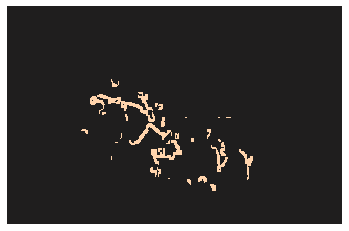

In [58]:
mask = local_polar_mask(image,hop=3)
sns.heatmap(mask,center=0,cbar=False,xticklabels=False, yticklabels=False)

In [69]:
# use non-maxima-suppression to thin the edges

def NMS(image,mask=None):
    gx = skimage.filters.prewitt_v(image) # positive if westwards
    gy = skimage.filters.prewitt_h(image) # positive if northwards
    
    phase = np.zeros_like(image)
    height = image.shape[0]
    width = image.shape[1]
    
    
    # coordinate explanation:
    #           pi/2
    #             ^
    #             ^
    #  0 <--- origin pixel ---> pi
    #             
    #         pi*(3/2)
    
    for i in range(height):
        for j in range(width):
            if gx[i,j]==0:
                continue
            if gx[i,j]>0 and gy[i,j]>0: # is Gx is pointing westwards, Gy is pointing northwards
                phase[i,j] = 180*np.arctan(gy[i,j]/gx[i,j])/np.pi
            elif gx[i,j]>0 and gy[i,j]<0: # is Gx is pointing westwards, Gy is pointing southwards
                phase[i,j] = 180*np.arctan(gy[i,j]/gx[i,j])/np.pi+360
            else:
                phase[i,j] = 180*np.arctan(gy[i,j]/gx[i,j])/np.pi+180
                
    # with the gradient direction calculated, we could do NMS
    edge_prewitt = skimage.filters.prewitt(image,mask=mask) # calculate the gradient of the image on specific pixels with local strong pos/neg
    edge_thin = np.zeros_like(edge_prewitt)
    
    if mask is not None:
        for i in range(height):
            for j in range(width):
                if mask[i,j]!=1 or gx[i,j]==0: # we should also add a check about whether [i,j] is a boundary pixel, but since mask typically ignores boundaries, we do not add the check here
                    continue
                if (phase[i][j] >= 337.5 or phase[i][j] < 22.5) or (phase[i][j] >= 157.5 and phase[i][j] < 202.5):
                    if (edge_prewitt[i,j]>edge_prewitt[i,j-1] and edge_prewitt[i,j]>edge_prewitt[i,j+1]):
                        edge_thin[i,j] = edge_prewitt[i,j]
                        
                if (phase[i][j] >= 22.5 and phase[i][j] < 67.5) or (phase[i][j] >= 202.5 and phase[i][j] < 247.5):
                    if (edge_prewitt[i,j]>edge_prewitt[i-1,j-1] and edge_prewitt[i,j]>edge_prewitt[i+1,j+1]):
                        edge_thin[i,j] = edge_prewitt[i,j]
                        
                if (phase[i][j] >= 67.5 and phase[i][j] < 112.5) or (phase[i][j] >= 247.5 and phase[i][j] < 292.5):
                    if (edge_prewitt[i,j]>edge_prewitt[i-1,j] and edge_prewitt[i,j]>edge_prewitt[i+1,j]):
                        edge_thin[i,j] = edge_prewitt[i,j]

                if (phase[i][j] >= 112.5 and phase[i][j] < 157.5) or (phase[i][j] >= 292.5 and phase[i][j] < 337.5):
                    if (edge_prewitt[i,j]>edge_prewitt[i-1,j+1] and edge_prewitt[i,j]>edge_prewitt[i+1,j-1]):
                        edge_thin[i,j] = edge_prewitt[i,j]
                        
        return edge_thin, phase
    

In [71]:
edge_thin, phase = NMS(image,mask=mask)

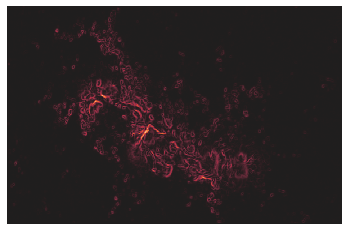

In [72]:
# use prewitt operator to calculate local gradients
prewitt_edge = skimage.filters.prewitt(image)
sns.heatmap(prewitt_edge,center=0,cbar=False,xticklabels=False, yticklabels=False)

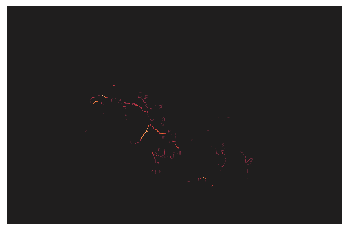

In [73]:
sns.heatmap(edge_thin,center=0,cbar=False,xticklabels=False, yticklabels=False)

In [74]:
hst_edge = skimage.filters.apply_hysteresis_threshold(edge_thin,PIL_min_gradi,PIL_max_gradi)

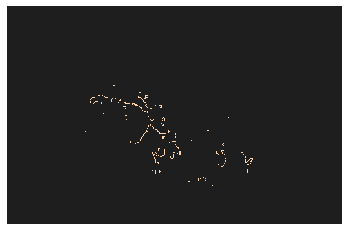

In [75]:
sns.heatmap(hst_edge,center=0,cbar=False,xticklabels=False, yticklabels=False)